In [285]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
scaler = MinMaxScaler()

In [266]:
df = pd.read_csv("credit_card_transactions.csv")
df.head()

,TransactionID,Time,Amount,CardholderName,MerchantName,MCC,Location,Device,IPAddress,TransactionSpeed,Fraud
0,1,2025-03-09 06:23:57,83.54,Sarah Murray,Oconnor-Hughes,5411,Longtown,Android,102.247.49.50,38.17,0
1,2,2025-02-14 05:17:36,805.88,Alexander Brooks,Reed PLC,5261,Woodsland,POS,153.157.50.7,49.84,0
2,3,2024-05-03 15:28:52,450.49,Harold Perez,Berry LLC,5261,Jessicatown,iOS,151.174.154.123,48.79,0
3,4,2024-05-03 09:01:14,782.39,Rebecca Davis,Berg Inc,5968,North Krystalburgh,Android,130.70.79.149,8.71,0
4,5,2025-04-24 17:24:39,713.02,Lauren Benson DDS,King-Gaines,5968,East Danielletown,Android,195.136.16.190,17.16,0


In [267]:
df.dtypes

TransactionID         int64
Time                 object
Amount              float64
CardholderName       object
MerchantName         object
MCC                   int64
Location             object
Device               object
IPAddress            object
TransactionSpeed    float64
Fraud                 int64
dtype: object

In [268]:
#Transformacion de datos
df['Time'] = pd.to_datetime(df['Time'], errors = 'coerce')
df['MCC'] = df['MCC'].astype(object)
df['Weekday'] = df['Time'].dt.weekday
df['Hour'] = df['Time'].dt.hour
df['Month'] = df['Time'].dt.month

In [269]:
df.dtypes

TransactionID                int64
Time                datetime64[ns]
Amount                     float64
CardholderName              object
MerchantName                object
MCC                         object
Location                    object
Device                      object
IPAddress                   object
TransactionSpeed           float64
Fraud                        int64
Weekday                      int32
Hour                         int32
Month                        int32
dtype: object

In [270]:
df.head()

,TransactionID,Time,Amount,CardholderName,MerchantName,MCC,Location,Device,IPAddress,TransactionSpeed,Fraud,Weekday,Hour,Month
0,1,2025-03-09 06:23:57,83.54,Sarah Murray,Oconnor-Hughes,5411,Longtown,Android,102.247.49.50,38.17,0,6,6,3
1,2,2025-02-14 05:17:36,805.88,Alexander Brooks,Reed PLC,5261,Woodsland,POS,153.157.50.7,49.84,0,4,5,2
2,3,2024-05-03 15:28:52,450.49,Harold Perez,Berry LLC,5261,Jessicatown,iOS,151.174.154.123,48.79,0,4,15,5
3,4,2024-05-03 09:01:14,782.39,Rebecca Davis,Berg Inc,5968,North Krystalburgh,Android,130.70.79.149,8.71,0,4,9,5
4,5,2025-04-24 17:24:39,713.02,Lauren Benson DDS,King-Gaines,5968,East Danielletown,Android,195.136.16.190,17.16,0,3,17,4


In [271]:
df.describe()

,TransactionID,Time,Amount,TransactionSpeed,Fraud,Weekday,Hour,Month
count,10000.00000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2024-10-30 03:27:20.494300160,547.347491,30.738446,0.019200,2.995400,11.525500,6.528300
min,1.00000,2024-05-01 07:29:17,10.090000,0.110000,0.000000,0.000000,0.000000,1.000000
25%,2500.75000,2024-07-31 11:55:39.500000,263.222500,14.910000,0.000000,1.000000,6.000000,4.000000
50%,5000.50000,2024-10-30 22:49:50,512.240000,29.655000,0.000000,3.000000,12.000000,7.000000
75%,7500.25000,2025-01-28 03:57:06.750000128,759.935000,45.270000,0.000000,5.000000,17.000000,10.000000
max,10000.00000,2025-05-01 09:39:46,4988.070000,119.860000,1.000000,6.000000,23.000000,12.000000
std,2886.89568,NaN,460.047329,19.092345,0.137234,1.991626,6.932341,3.467795


In [272]:
df = df.drop(['CardholderName','TransactionID', 'Time'], axis=1)
df.isna().sum()

Amount              0
MerchantName        0
MCC                 0
Location            0
Device              0
IPAddress           0
TransactionSpeed    0
Fraud               0
Weekday             0
Hour                0
Month               0
dtype: int64

In [273]:
df['Fraud'].value_counts()

Fraud
0    9808
1     192
Name: count, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc7d15a0910>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc7d15a0b90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc7d15a07d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc7d15a0e10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc7d15a0f50>],
 'means': []}

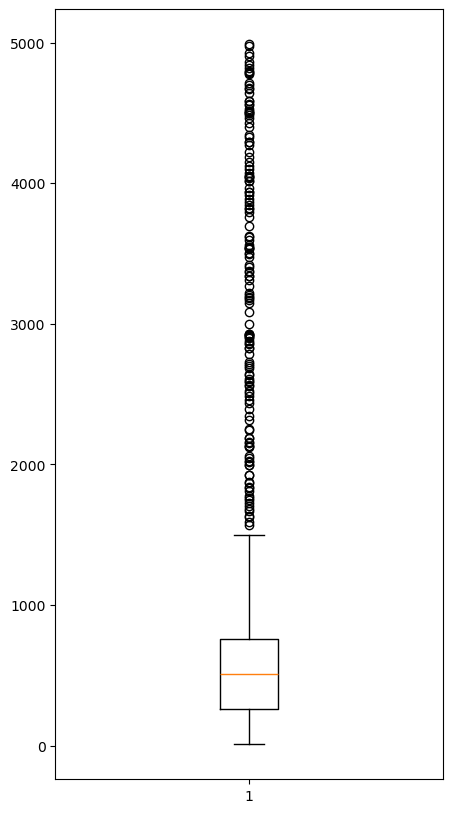

In [274]:
plt.figure(figsize=(5,10))
plt.boxplot(df['Amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc7d15db9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc7d15dbc50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc7d15db890>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc7d15dbed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc7d141c050>],
 'means': []}

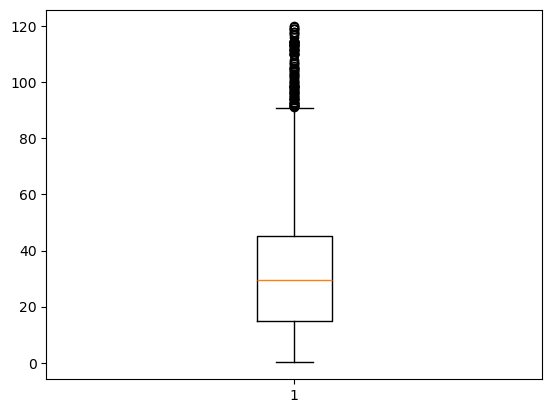

In [275]:
plt.boxplot(df['TransactionSpeed'])

In [276]:
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

top_limit = Q3 + 1.5 * IQR

df['isLargeAmount'] = (df['Amount'] > top_limit).astype(int)


Q1 = df['TransactionSpeed'].quantile(0.25)
Q3 = df['TransactionSpeed'].quantile(0.75)
IQR = Q3 - Q1

# Límite superior para detectar outliers
top_limit = Q3 + 1.5 * IQR

# Nueva columna
df['is_slow_transaction'] = (df['TransactionSpeed'] > top_limit).astype(int)


In [277]:
df.head()

,Amount,MerchantName,MCC,Location,Device,IPAddress,TransactionSpeed,Fraud,Weekday,Hour,Month,isLargeAmount,is_slow_transaction
0,83.54,Oconnor-Hughes,5411,Longtown,Android,102.247.49.50,38.17,0,6,6,3,0,0
1,805.88,Reed PLC,5261,Woodsland,POS,153.157.50.7,49.84,0,4,5,2,0,0
2,450.49,Berry LLC,5261,Jessicatown,iOS,151.174.154.123,48.79,0,4,15,5,0,0
3,782.39,Berg Inc,5968,North Krystalburgh,Android,130.70.79.149,8.71,0,4,9,5,0,0
4,713.02,King-Gaines,5968,East Danielletown,Android,195.136.16.190,17.16,0,3,17,4,0,0


In [278]:
fraudes = df[df['Fraud'] == 1]
no_fraudes = df[df['Fraud'] == 0].sample(n=500, random_state=42) 

df_balanceado = pd.concat([fraudes, no_fraudes])

df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)


In [279]:

categoricFeatures = ['MerchantName','Location', 'IPAddress', 'MCC', 'Device']
numericFeatures = ['Amount', 'Hour', 'TransactionSpeed']

#Normalizacion para categoricas
for col in categoricFeatures:
      df_balanceado[col] = LabelEncoder().fit_transform(df_balanceado[col])

#Normalizacion para numericas
df_balanceado[numericFeatures] = scaler.fit_transform(df_balanceado[numericFeatures])
df_balanceado['Fraud'].value_counts()

Fraud
0    500
1    192
Name: count, dtype: int64

In [280]:
#Aislamos labels
x = df_balanceado.drop(['Fraud'], axis= 1 )
y = df_balanceado['Fraud']

In [281]:
#Split test and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [282]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       101
           1       1.00      0.82      0.90        38

    accuracy                           0.95       139
   macro avg       0.97      0.91      0.93       139
weighted avg       0.95      0.95      0.95       139



In [283]:
print(confusion_matrix(y_test, y_pred))

[[101   0]
 [  7  31]]


In [286]:
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_train, y_train)

for feature, score in zip(X_train.columns, selector.scores_):
    print(f"{feature}: {score:.2f}")

Amount: 104.93
MerchantName: 18.29
MCC: 1.11
Location: 112.08
Device: 0.40
IPAddress: 45.70
TransactionSpeed: 76.13
Weekday: 1.38
Hour: 0.08
Month: 0.62
isLargeAmount: 313.50
is_slow_transaction: 209.86
